In [3]:
!pip install rdkit duckdb matplotlib_venn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 61.9 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyarrow as pa
import pyarrow.parquet as pq

from tqdm import tqdm
from pathlib import Path
import itertools
from collections import defaultdict

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from rdkit.Chem import rdmolops
from collections import Counter

import seaborn as sns
from collections import Counter
from matplotlib_venn import venn2, venn3

train_pq = pq.ParquetFile("/content/drive/MyDrive/DS5500/train.parquet")

SAVEDIR = Path("/content/drive/MyDrive/DS5500/")
SAVEDIR.mkdir(exist_ok=True)

DRAFT_MODE = False


train_path = '/content/drive/MyDrive/DS5500/train.parquet'
test_path = '/content/drive/MyDrive/DS5500/test.parquet'

con = duckdb.connect()

In [6]:
df_train = pd.read_parquet(train_path)
df_test = pd.read_parquet(test_path)

In [8]:
df_train.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,0,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,BRD4,0
1,1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,HSA,0
2,2,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,sEH,0
3,3,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,BRD4,0
4,4,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,HSA,0


In [34]:
df_ones = df_train[df_train['binds']==1]

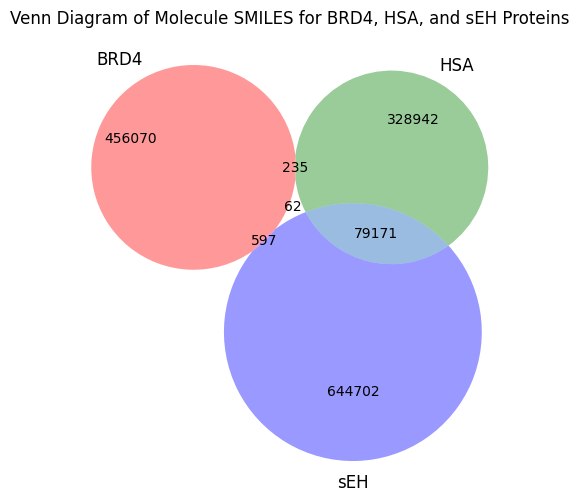

In [41]:
# Group by SMILES to get the list of proteins associated with each SMILES
smiles_groups = df_ones.groupby('molecule_smiles')['protein_name'].apply(set).reset_index()

# Extract sets of SMILES for each category
brd4_only = set(smiles_groups[smiles_groups['protein_name'] == {'BRD4'}]['molecule_smiles'])
hsa_only = set(smiles_groups[smiles_groups['protein_name'] == {'HSA'}]['molecule_smiles'])
seh_only = set(smiles_groups[smiles_groups['protein_name'] == {'sEH'}]['molecule_smiles'])
brd4_hsa = set(smiles_groups[smiles_groups['protein_name'] == {'BRD4', 'HSA'}]['molecule_smiles'])
brd4_seh = set(smiles_groups[smiles_groups['protein_name'] == {'BRD4', 'sEH'}]['molecule_smiles'])
hsa_seh = set(smiles_groups[smiles_groups['protein_name'] == {'HSA', 'sEH'}]['molecule_smiles'])
all_three = set(smiles_groups[smiles_groups['protein_name'] == {'BRD4', 'HSA', 'sEH'}]['molecule_smiles'])

# Create the Venn diagram with these sets
plt.figure(figsize=(8, 6))
venn3([brd4_only | brd4_hsa | brd4_seh | all_three,
       hsa_only | brd4_hsa | hsa_seh | all_three,
       seh_only | brd4_seh | hsa_seh | all_three],
      ('BRD4', 'HSA', 'sEH'))
plt.title("Venn Diagram of Molecule SMILES for BRD4, HSA, and sEH Proteins")

# Save the plot as a PNG file
output_path = "/content/drive/MyDrive/DS5500/venn_diagram_smiles_proteins.png"
plt.savefig(output_path)

# Display the plot
plt.show()


In [32]:
df_train['molecule_smiles'].duplicated()

,molecule_smiles
0,False
1,True
2,True
3,False
4,True
...,...
295246825,True
295246826,True
295246827,False
295246828,True


In [7]:
import pandas as pd

# Define file paths
zeros_file_path = '/content/drive/MyDrive/DS5500/mol_detailed_features_0.parquet'
ones_file_path = '/content/drive/MyDrive/DS5500/mol_detailed_features_1.parquet'

# Read the Parquet files into DataFrames
df_zeros = pd.read_parquet(zeros_file_path)
df_ones = pd.read_parquet(ones_file_path)

KeyboardInterrupt: 

In [ ]:
df_ones_ = df_ones.drop(columns=['MW', 'AROMATIC','RINGS'], axis=1)

In [ ]:
df_zeros_ = df_zeros.drop(columns=['MW', 'AROMATIC','RINGS'], axis=1)

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdmolops
from joblib import Parallel, delayed
from tqdm import tqdm

# Function to calculate molecular descriptors
def mol_desc(smiles):
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        return None  # Handle invalid SMILES

    # Get molecular descriptors
    des_molWt = Descriptors.MolWt(mol)  # Molecular weight
    des_MolLogP = Descriptors.MolLogP(mol)  # LogP (partition coefficient)
    des_NumHDonors = Lipinski.NumHDonors(mol)  # Number of hydrogen donors
    des_NumHAcceptors = Lipinski.NumHAcceptors(mol)  # Number of hydrogen acceptors
    tpsa = Descriptors.TPSA(mol)  # Topological Polar Surface Area (TPSA)
    rotatable_bonds = Descriptors.NumRotatableBonds(mol)  # Rotatable bonds count
    aromatic_rings = Descriptors.NumAromaticRings(mol)  # Aromatic ring count

    # Get the total number of rings in the molecule
    ssr = rdmolops.GetSymmSSSR(mol)  # Smallest Set of Smallest Rings
    total_rings = len(ssr)

    # Get the total number of rings in the molecule
    ssr = rdmolops.GetSymmSSSR(mol)  # Smallest Set of Smallest Rings
    total_rings = len(ssr)

    # Calculate Hydrophilicity
    hydrophilicity = des_NumHDonors + des_NumHAcceptors

    # Calculate aromatic ring ratio
    aromatic_ring_ratio = aromatic_rings / total_rings if total_rings > 0 else 0


    # Create a dictionary of the molecular descriptors
    descriptor_dict = {
        'molecule_smiles': smiles,
        'MolWt': des_molWt,
        'MolLogP': des_MolLogP,
        'NumHDonors': des_NumHDonors,
        'NumHAcceptors': des_NumHAcceptors,
        'Hydrophilicity': hydrophilicity,
        'TPSA': tpsa,
        'RotatableBonds': rotatable_bonds,
        'AromaticRings': aromatic_rings,
        'TotalRings': total_rings,
        'AromaticRingRatio': aromatic_ring_ratio
    }
    # Convert the dictionary into a DataFrame with one row
    df_mol_desc = pd.DataFrame(descriptor_dict, index=[0])
    return df_mol_desc


In [ ]:
# A list of SMILES strings in `smiles_ones_list`
smiles_ones_list = df_ones_['SMILES'].tolist()

# Use Parallel processing with joblib, and tqdm for the progress bar
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(mol_desc)(smiles) for smiles in (smiles_ones_list)
)

# Filter out None results (in case there were invalid SMILES)
results = [r for r in results if r is not None]

# Concatenate the results into a single DataFrame
df_descriptors_ones = pd.concat(results, ignore_index=True)

# Concatenate with the original df_ones_ DataFrame
df_combined_ones = pd.concat([df_ones_, df_descriptors_ones], axis=1)


# Save the DataFrame to a compressed CSV file
df_combined_ones.to_csv('/content/drive/MyDrive/DS5500/mol_detailed_features_1_v2.zip', index=False, compression='zip')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1937561214221952s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.02811717987060547s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.027040958404541016s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.058861732482910156s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12149882316589355s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:    3.3s
[Parall

In [ ]:
df_combined_ones.head()

In [ ]:
# A list of SMILES strings in `smiles_zeros_list`
smiles_zeros_list = df_zeros_['SMILES'].tolist()

# Use Parallel processing with joblib, and tqdm for the progress bar
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(mol_desc)(smiles) for smiles in tqdm(smiles_zeros_list)
)

# Filter out None results (in case there were invalid SMILES)
results = [r for r in results if r is not None]

# Concatenate the results into a single DataFrame
df_descriptors_zeros = pd.concat(results, ignore_index=True)

# Concatenate with the original df_ones_ DataFrame
df_combined_zeros = pd.concat([df_zeros_, df_descriptors_zeros], axis=1)


print(df_combined_zeros.head())


# Save the DataFrame to a compressed CSV file
df_combined_zeros.to_csv('/content/drive/MyDrive/DS5500/mol_detailed_features_0_v2.zip', index=False, compression='zip')

  0%|          | 192/7548895 [00:07<72:38:05, 28.87it/s][Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    8.2s
  0%|          | 288/7548895 [00:08<43:18:42, 48.41it/s][Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.4s
  0%|          | 384/7548895 [00:08<28:34:04, 73.40it/s][Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 229 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:    8.7s
  0%|          | 480/7548895 [00:08<20:08:08, 104.13it/s][Parallel(n_jobs=-1)]: Done 320

In [ ]:
df_combined_zeros.head()